In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle

In [2]:
def load_data(path):
    with open(path) as fil:
        data = pd.read_csv(fil,sep='\t',header=None,names=["hi","en",""],skip_blank_lines=True,index_col=None)
    data = data[data['hi'].notna()]
    data = data[data['en'].notna()]
    data = data[['hi','en']]
    return data

In [3]:
train = load_data("hi.translit.sampled.train.tsv")
dev = load_data("hi.translit.sampled.dev.tsv")
test = load_data("hi.translit.sampled.test.tsv")

In [4]:
train.head()

,hi,en
0,अं,an
1,अंकगणित,ankganit
2,अंकल,uncle
3,अंकुर,ankur
4,अंकुरण,ankuran


In [5]:
x = train['en'].values
y = train['hi'].values
y = '\t'+y+'\n'

In [6]:
english_tokens = set()
hindi_tokens = set()

for xx,yy in zip(x,y):
    for ch in xx:
        english_tokens.add(ch)
    for ch in yy:
        hindi_tokens.add(ch)
    
english_tokens = sorted(list(english_tokens))
hindi_tokens = sorted(list(hindi_tokens))

In [7]:
eng_token_map = dict([(ch,i+1) for i,ch in enumerate(english_tokens)])
hin_token_map = dict([(ch,i+1) for i,ch in enumerate(hindi_tokens)])

In [8]:
hin_token_map[" "] = 0
eng_token_map[" "] = 0

In [9]:
max_eng_len = max([len(i) for i in x])
max_hin_len = max([len(i) for i in y])

In [10]:
def process(data):
    x,y = data['en'].values, data['hi'].values
    y = "\t" + y + "\n"
    
    a = np.zeros((len(x),max_eng_len),dtype="float32")
    b = np.zeros((len(y),max_hin_len),dtype="float32")
    c = np.zeros((len(y),max_hin_len,len(hindi_tokens)+1),dtype="int")
    
    
    for i,(xx,yy) in enumerate(zip(x,y)):
        for j,ch in enumerate(xx):
            a[i,j] = eng_token_map[ch]

        a[i,j+1:] = eng_token_map[" "]
        for j,ch in enumerate(yy):
            b[i,j] = hin_token_map[ch]

            if j>0:
                c[i,j-1,hin_token_map[ch]] = 1

        b[i,j+1:] = hin_token_map[" "]
        c[i,j:,hin_token_map[" "]] = 1
        
    return a,b,c

In [11]:
trainx, trainxx, trainy = process(train)
valx, valxx, valy = process(dev)
testx,testxx,testy = process(test)

In [12]:
np.random.seed(42)

In [13]:
reverse_eng_map = dict([(i,char) for char,i in eng_token_map.items()])
reverse_hin_map = dict([(i,char) for char,i in hin_token_map.items()])

## Training

In [14]:
from tensorflow import keras
import tensorflow as tf
from keras.layers import SimpleRNN,LSTM,GRU,Embedding,Dense,Dropout,Input,Concatenate
from keras.optimizers import Adam,Nadam
from keras import Model

In [15]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [16]:
class Attention(tf.keras.layers.Layer):
    def __init__(self, units,name=None, **kwargs):
        super(Attention, self).__init__(name=name)
        self.W1 = Dense(units,name='w1')
        self.W2 = Dense(units,name='w2')
        self.V = Dense(1,name='v')
        self.units = units
        super(Attention, self).__init__(**kwargs)

    def call(self, tup):
        # query hidden state shape == (batch_size, hidden size)
        # query_with_time_axis shape == (batch_size, 1, hidden size)
        # values shape == (batch_size, max_len, hidden size)
        # we are doing this to broadcast addition along the time axis to calculate the score
        query = tup[0]
        values = tup[1]
        query_with_time_axis = tf.expand_dims(query, 1)
        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(
            self.W1(query_with_time_axis) + self.W2(values)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)
        

        return context_vector, attention_weights
    
        
    def get_config(self):
        config = super(Attention,self).get_config()
        config.update({
            'units': self.units
        })
        return config

In [17]:
def accuracy1(real,pred):
    real = tf.math.argmax(real,axis=2)
    pred = tf.math.argmax(pred,axis=2)
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    acc = tf.math.equal(real,pred)
    mask = tf.cast(mask, dtype='int32')
    acc = tf.cast(acc, dtype='int32')
    acc = tf.math.multiply(acc,mask)
    mask = tf.reduce_sum(mask,axis=1)
    acc = tf.reduce_sum(acc,axis=1)
    acc = tf.math.equal(acc,mask)
    acc = tf.cast(acc, dtype='float32')
    return tf.reduce_mean(acc)

In [18]:
def build_model(cell = "LSTM",nunits = 32, enc_layers = 1, dec_layers = 1,embed_dim = 32,dense_size=32,dropout=None):
    keras.backend.clear_session()
    encoder_inputs = Input(shape=(None,),name='input1')
    encoder_embedding = Embedding(input_dim=len(english_tokens)+1,output_dim = embed_dim,mask_zero=True,name="enc_embed")
    encoder_context = encoder_embedding(encoder_inputs)
    decoder_inputs = Input(shape=(None,),name='input2')
    decoder_embedding = Embedding(input_dim = len(hindi_tokens)+1,output_dim = embed_dim,mask_zero=True,name="dec_embed")
    decoder_context = decoder_embedding(decoder_inputs)
    attention = Attention(nunits,name='attention')
    tot_out = []
    concat1 = Concatenate(axis=-1,name='concat1')
    concat2 = Concatenate(axis=1,name='concat2')    
    if cell == "LSTM":
        encoder_prev = [LSTM(nunits,return_sequences=True,name=f"enc_{i}") for i in range(enc_layers-1)]
        encoder_fin = LSTM(nunits,return_sequences=True,return_state=True,name=f"enc_{enc_layers-1}")
        temp = encoder_context
        for x,lay in enumerate(encoder_prev):
            temp = lay(temp)
            if dropout is not None:
                temp = Dropout(dropout,name=f'do_{x}')(temp)
            
        enc_out = encoder_fin(temp)
        dec_states = enc_out[1:]
        
        decoder = [LSTM(nunits,return_sequences=True,return_state=True,name=f"dec_{i}") for i in range(dec_layers)]
        temp_states = [dec_states]*dec_layers
        
        for i in range(max_hin_len):
            tup = (temp_states[0][0],enc_out[0])
            context,att_wts = attention(tup)
            temp = concat1([tf.expand_dims(context, 1), decoder_context[:,i:i+1,:]])
#             temp = tf.expand_dims(temp, 1)
            for i in range(dec_layers):
                temp,sh,sc = decoder[i](temp,initial_state=temp_states[i])
                temp_states[i] = [sh,sc]
            tot_out.append(temp)
            
        outt = concat2(tot_out)
       
    elif cell == "GRU":
        encoder_prev = [GRU(nunits,return_sequences=True,name=f"enc_{i}") for i in range(enc_layers-1)]
        encoder_fin = GRU(nunits,return_sequences=True,return_state=True,name=f"enc_{enc_layers-1}")
        temp = encoder_context
        for x,lay in enumerate(encoder_prev):
            temp = lay(temp)
            if dropout is not None:
                temp = Dropout(dropout,name=f'do_{x}')(temp)
            
        enc_out = encoder_fin(temp)
        dec_states = enc_out[1:]
        
        decoder = [GRU(nunits,return_sequences=True,return_state=True,name=f"dec_{i}") for i in range(dec_layers)]
        temp_states = []
        for _ in range(dec_layers):
            temp_states += dec_states
        
        for i in range(max_hin_len):
            tup = (temp_states[0],enc_out[0])
            context,att_wts = attention(tup)
            temp = concat1([tf.expand_dims(context, 1), decoder_context[:,i:i+1,:]])
#             temp = tf.expand_dims(temp, 1)
            for i in range(dec_layers):
                temp,st = decoder[i](temp,initial_state=temp_states[i])
                temp_states[i] = st
            tot_out.append(temp)
            
        outt = concat2(tot_out)
            
        
    dense_lay1 = Dense(dense_size,activation='relu',name='dense1')
    pre_out = dense_lay1(outt)
    dense_lay2 = Dense(len(hindi_tokens)+1,activation = 'softmax',name='dense2')
    final_output = dense_lay2(pre_out)
    
    train = Model([encoder_inputs,decoder_inputs],final_output)
    
    return train
#     return train

In [22]:
train = build_model(nunits=256,
                    dense_size=256,
                    enc_layers=3,
                    dec_layers=1,
                    cell = "GRU",
                    dropout = 0.2,
                    embed_dim = 128)
train.compile(optimizer = Adam(),loss='categorical_crossentropy',metrics=['accuracy',accuracy1])

In [23]:
model_cb = tf.keras.callbacks.ModelCheckpoint('best_model_attention.h5',monitor='val_accuracy1',mode='max',save_best_only=True,verbose=1)

In [24]:
train.fit([trainx,trainxx],trainy,
             batch_size=128,
             validation_data = ([valx,valxx],valy),
             epochs=10,
             callbacks=[model_cb])

Epoch 1/10
346/346 [==============================] - ETA: 0s - loss: 1.0828 - accuracy: 0.7308 - accuracy1: 1.1290e-04
Epoch 00001: val_accuracy1 improved from -inf to 0.00022, saving model to best_model_attention.h5
346/346 [==============================] - 45s 130ms/step - loss: 1.0828 - accuracy: 0.7308 - accuracy1: 1.1290e-04 - val_loss: 0.8310 - val_accuracy: 0.7718 - val_accuracy1: 2.2321e-04
Epoch 2/10
346/346 [==============================] - ETA: 0s - loss: 0.6295 - accuracy: 0.8244 - accuracy1: 0.0349
Epoch 00002: val_accuracy1 improved from 0.00022 to 0.16659, saving model to best_model_attention.h5
346/346 [==============================] - 35s 102ms/step - loss: 0.6295 - accuracy: 0.8244 - accuracy1: 0.0349 - val_loss: 0.3081 - val_accuracy: 0.9134 - val_accuracy1: 0.1666
Epoch 3/10
346/346 [==============================] - ETA: 0s - loss: 0.2430 - accuracy: 0.9260 - accuracy1: 0.2302
Epoch 00003: val_accuracy1 improved from 0.16659 to 0.30908, saving model to best_mod

In [38]:
train.save('best_model_attention.h5')

## Inference

In [22]:
keras.backend.clear_session()
model = keras.models.load_model('best_model_attention.h5',custom_objects={'accuracy1':accuracy1,'Attention':Attention})

In [25]:
def inference_models(model,nunits=32,enc_layers=1,dec_layers=1,cell='LSTM',dropout=None):
    keras.backend.clear_session()
    encoder_inputs = model.input[0]
    encoder_embedding = model.get_layer('enc_embed')
    encoder_context = encoder_embedding(encoder_inputs)
    decoder_inputs = model.input[1]
    decoder_embedding = model.get_layer('dec_embed')
    decoder_context = decoder_embedding(decoder_inputs)
    
    
    encoder_prev = [model.get_layer(f'enc_{i}') for i in range(enc_layers-1)]
    encoder_fin = model.get_layer(f'enc_{enc_layers-1}')
    temp = encoder_context
    for i,lay in enumerate(encoder_prev):
        temp = lay(temp)
        if dropout is not None:
            temp = model.get_layer(f'do_{i}')(temp)
     
    if cell == "LSTM":
        enc_out, state_h,state_c = encoder_fin(temp)
        enc_final = [enc_out,state_h,state_c]
        
    elif cell == "GRU":
        enc_out, state = encoder_fin(temp)
        enc_final = [enc_out,state]

    encoder_model = keras.models.Model(encoder_inputs,enc_final)
    
    
    decoder = [model.get_layer(f'dec_{i}') for i in range(dec_layers)]
    
    attention = model.get_layer('attention')
    
    concat1 = model.get_layer('concat1')

    if cell == "LSTM":
        state_inputs = []
        state_outputs = []
        
        encout_input = Input(shape=(None,nunits),name='inputenc')
        
        temp = decoder_context[:,-1:,:]
                                                                  
        for i in range(dec_layers):
            decoder_input_h = Input(shape=(nunits,),name=f"inputh{i}")
            decoder_input_c = Input(shape=(nunits,),name=f"inputc{i}")
            
            if i==0:
                tup = (decoder_input_h,encout_input)
                context,att_wts_out = attention(tup)
                temp = concat1([tf.expand_dims(context, 1), temp])
                
            temp,sh,sc = decoder[i](temp,initial_state = [decoder_input_h,decoder_input_c])
            state_inputs += [decoder_input_h,decoder_input_c]
            state_outputs += [sh,sc]
            
        decoder_input_pass = [decoder_inputs,encout_input] + state_inputs

    elif cell == "GRU":
        state_inputs = []
        state_outputs = []
        
        encout_input = Input(shape=(None,nunits),name='inputenc')
        
        temp = decoder_context[:,:1,:]
                                                                  
        for i in range(dec_layers):
            state_input = Input(shape=(nunits,),name=f"inputs{i}")
            
            if i==0:
                tup = (state_input,encout_input)
                context,att_wts_out = attention(tup)
                temp = concat1([tf.expand_dims(context, 1), temp])
                
            temp,s = decoder[i](temp,initial_state = state_input)
            state_inputs.append(state_input)
            state_outputs.append(s)
            
        decoder_input_pass = [decoder_inputs,encout_input] + state_inputs

    pre_out = model.get_layer('dense1')(temp)
    final_output = model.get_layer('dense2')(pre_out)

    decoder_model = keras.models.Model(decoder_input_pass, [final_output,att_wts_out]+state_outputs)
    
    return encoder_model,decoder_model

In [26]:
enc,dec = inference_models(train,nunits=256,enc_layers=3,dec_layers=1,cell="GRU",dropout='yes')

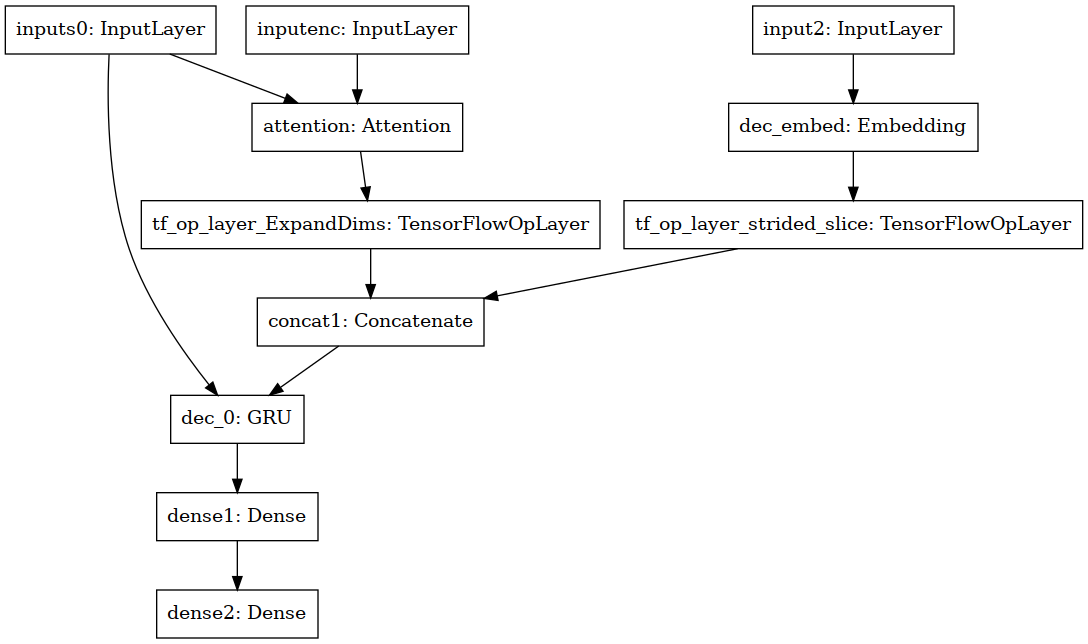

In [27]:
keras.utils.plot_model(dec)

In [28]:
dec.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs0 (InputLayer)            [(None, 256)]        0                                            
__________________________________________________________________________________________________
inputenc (InputLayer)           [(None, None, 256)]  0                                            
__________________________________________________________________________________________________
input2 (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
attention (Attention)           ((None, 256), (None, 131841      inputs0[0][0]                    
                                                                 inputenc[0][0]             

In [29]:
enc.save('best_enc_attention.h5')
dec.save('best_dec_attention.h5')

In [29]:
import time

In [30]:
def beam_search(inp,k,dec_layers,cell="LSTM"):
    enc_out = enc.predict(inp)
    statess = enc_out[1:]
    target_seq = np.zeros((inp.shape[0],1))
    target_seq[:,0] = hin_token_map["\t"]
    if cell == "LSTM":
        states = []
        for i in range(dec_layers):
            states += [statess[0],statess[1]]
    else:
        states = []
        for i in range(dec_layers):
            states += [statess]
            
    output = dec.predict([target_seq,enc_out[0]]+states)
    states = output[2:]
    
    stat1 = np.asarray(states).transpose([1,0,2])
    
    best_chars = np.argsort(output[0][:,-1,:],axis=-1)[:,-k:]
    scores = np.sort(output[0][:,-1,:],axis=-1)[:,-k:]
    sequences = [[([ch],-np.log(sc),stat1[i],0,output[1][i]) for ch,sc in zip(best_chars[i],scores[i])] for i in range(inp.shape[0])]
    
    for t1 in range(max_hin_len-1):
        candidates = [[] for _ in range(inp.shape[0])]
        for j in range(k):
            target_seq[:,0] = [sequences[i][j][0][-1] for i in range(inp.shape[0])]
            states = list(np.asarray([sequences[i][j][2] for i in range(inp.shape[0])]).transpose([1,0,2]))
            output = dec.predict([target_seq,enc_out[0]]+states,batch_size=32)
            best_chars = np.argsort(output[0][:,-1,:],axis=-1)[:,-k:]
            scores = np.sort(output[0][:,-1,:],axis=-1)[:,-k:]
            
            stat1 = np.asarray(output[2:]).transpose([1,0,2])
            
            for i in range(inp.shape[0]):
                chk = 1 if (sequences[i][j][3]==1 or sequences[i][j][0][-1] == hin_token_map["\n"]) else 0
                if chk == 0:
                    candidates[i] += [(sequences[i][j][0]+[best_chars[i,rep]],
                                       sequences[i][j][1]-np.log(scores[i,rep]),
                                       stat1[i],
                                       chk,
                                       np.concatenate((sequences[i][j][4],output[1][i]),axis=1))
                                      for rep in range(k)]
                else:
                    candidates[i] += [sequences[i][j]]
                    
        for i in range(inp.shape[0]):
            candidates[i] = sorted(candidates[i],key = lambda tup:tup[1]/len(tup[0]))
            sequences[i] = candidates[i][:k]
            
        print(f"decoder {t1} done")
            
        
    res = [list() for i in range(inp.shape[0])]
    att_wts = [list() for i in range(inp.shape[0])]
    for i in range(inp.shape[0]):
        for j in range(k):
            res[i].append(sequences[i][j][0])
            att_wts[i].append(sequences[i][j][4])
        
    return res,att_wts

In [31]:
start = time.time()
pred1,att_wts = beam_search(testx,5,1,cell="GRU")
print(time.time()-start)

decoder 0 done
decoder 1 done
decoder 2 done
decoder 3 done
decoder 4 done
decoder 5 done
decoder 6 done
decoder 7 done
decoder 8 done
decoder 9 done
decoder 10 done
decoder 11 done
decoder 12 done
decoder 13 done
decoder 14 done
decoder 15 done
decoder 16 done
decoder 17 done
decoder 18 done
decoder 19 done
54.599345445632935


In [32]:
acc = 0

for i,pre in enumerate(pred1):
    chk = 0
    
    for pr in pre:
        fl = 1
        for j,ch in enumerate(pr):
            if ch!=np.argmax(testy[i,j,:]):
                fl=0
                break
            if ch==hin_token_map["\n"]:
                break
        chk = chk or fl
        
    if chk==1:
        acc+=1
        
        
print(acc/len(pred1))

0.7365615282096846


In [34]:
ans = []
ans1 = []
acc = 0

for i,pre in enumerate(pred1):
    word = []
    word1 = []
    
    orig = ""
    for ch in testx[i]:
        if reverse_eng_map[ch] == " ":
            break
        orig += reverse_eng_map[ch]
    word.append(orig)
    word1.append(orig)
    
    hind = ""
    for ch in testxx[i,1:]:
        if reverse_hin_map[ch] == "\n":
            break
        hind += reverse_hin_map[ch]
    
    word.append(hind)
    word1.append(hind)
    
    fl=0
    
    for j,pr in enumerate(pre):
        deco1 = ""
        for ch in pr:
            if reverse_hin_map[ch] == "\n":
                break
            deco1 += reverse_hin_map[ch]
        word.append(deco1)
        if j==0:
            word1.append(deco1)
            
        
            if hind==deco1:
                fl=1
            
    if fl==1:
        acc += 1
        
    ans.append(word)
    ans1.append(word1)
    
print(acc/len(ans))

0.3998223011994669


In [35]:
df = pd.DataFrame(ans,columns=['English','Hindi']+[f'Hindi_pred_{i}' for i in range(5)])
df.sample(n=5)

,English,Hindi,Hindi_pred_0,Hindi_pred_1,Hindi_pred_2,Hindi_pred_3,Hindi_pred_4
1634,dredger,ड्रेजर,ड्रेजर,ड्रीजर,ड्रेडर,ड्रैजर,ड्रेजन
3691,wajood,वजूद,वाजूद,वजूद,वाजुद,वाजुदू,वजुद
2977,bhugta,भुगता,भुगता,भूगता,भुग्ता,भुगटा,भूगटा
3558,laksar,लक्सर,लक्सर,लाक्सर,लकसर,लाकसर,लक्षर
468,udar,उदर,उदर,उदार,उड़ार,उड़र,उद्दर


In [36]:
df.to_csv('predictions_attention_beam.csv')

In [37]:
df1 = pd.DataFrame(ans1,columns=['English','Hindi','Hindi_pred'])
df1.sample(n=5)
df1.to_csv('predictions_attention.csv')

## Question 5(d)

In [207]:
from matplotlib.font_manager import FontProperties
import matplotlib.ticker as ticker
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

mpl.rcParams['font.sans-serif'] = ["Arial Unicode MS"]

def plot_attention(attention, sentence, predicted_sentence,orig,hind,deco):
    
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(1, 1, 1)
    plott = ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}
    hindi_font = FontProperties(fname = 'VesperLibre-Regular.ttf')
    
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontproperties=hindi_font, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    title = f"Original word in english: {orig}\nOriginal word in hindi: {hind}\nDecoded word in hindi: {deco}"
    
    fontdict = {'fontsize': 18}
    plt.title(title,fontproperties=hindi_font, fontsize=14,y=-.3)
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(plott,cax=cax)
    
    plt.tight_layout()
    plt.savefig(f'res/{orig}.png', bbox_inches = 'tight')
    plt.show()

Original word in english: vineet
Original word in hindi: विनीत
Decoded word in hindi: विनीत


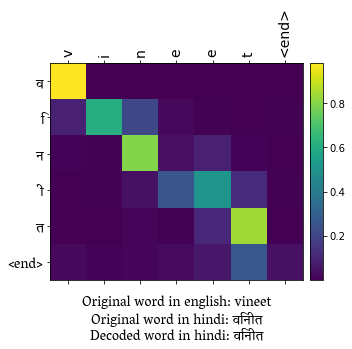

Original word in english: ambaani
Original word in hindi: अंबानी
Decoded word in hindi: अंबानी


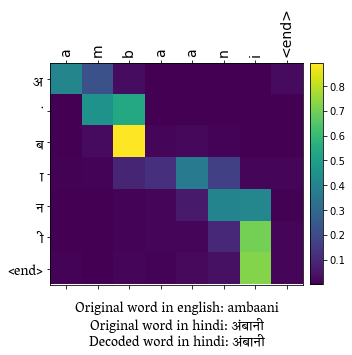

Original word in english: bhooswaami
Original word in hindi: भूस्वामी
Decoded word in hindi: भूसवामी


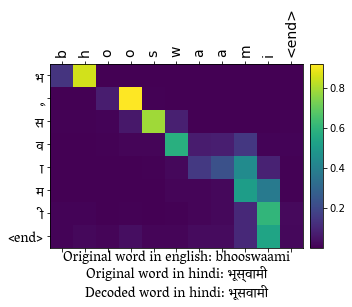

Original word in english: aayenge
Original word in hindi: आयेंगे
Decoded word in hindi: आएंगे


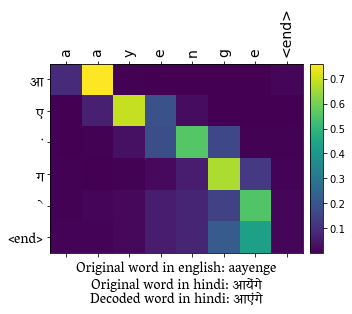

Original word in english: chhetr
Original word in hindi: छेत्र
Decoded word in hindi: छेत्र


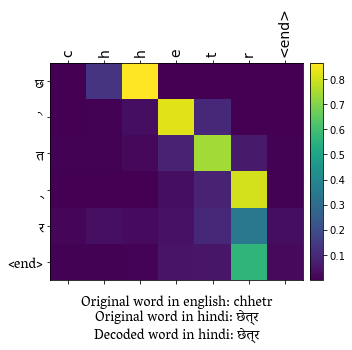

Original word in english: vipreetataa
Original word in hindi: विपरीतता
Decoded word in hindi: विप्रीतता


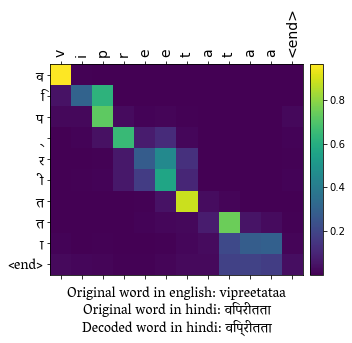

Original word in english: bnaam
Original word in hindi: बनाम
Decoded word in hindi: बनाम


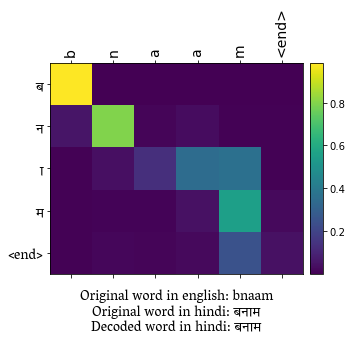

Original word in english: istife
Original word in hindi: इस्तीफे
Decoded word in hindi: आइस्टिफ


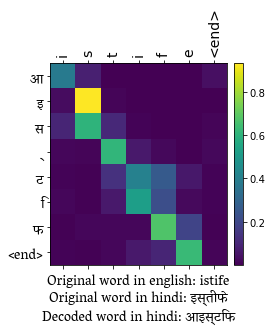

Original word in english: dang
Original word in hindi: दंग
Decoded word in hindi: डंग


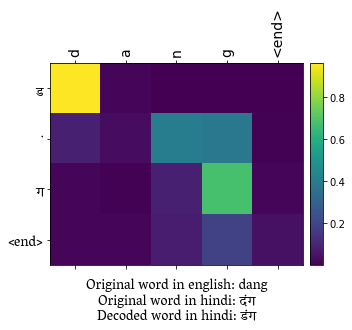

In [209]:
eve = df.values

for _ in range(9):
    sp = np.random.choice(eve.shape[0])

    decoded_sentence_list = [x for x in eve[sp][2].strip()] + ['<end>']
    input_sentence_list = [x for x in eve[sp][0].strip()] + ['<end>']

    attention_plot = att_wts[sp][0][:len(input_sentence_list),:len(decoded_sentence_list)].T

    print("Original word in english:", eve[sp][0])
    print("Original word in hindi:", eve[sp][1])
    print("Decoded word in hindi:", eve[sp][2])

    plot_attention(attention_plot, input_sentence_list, decoded_sentence_list,eve[sp][0],eve[sp][1],eve[sp][2])


## Question 6

In [47]:
from IPython.display import HTML as html_print
from IPython.display import display

In [191]:
# get html element
def cstr(s, color='black'):
    if s == ' ':
        return "<text style=color:#000;padding-left:10px;background-color:{}> </text>".format(color, s)
    else:
        return "<text style=color:#000;background-color:{}>{} </text>".format(color, s)

# print html
def print_color(t,ch):
    display(html_print(''.join([cstr(ch,color='#fffff')]+[cstr(' ',color='#fffff') for _ in range(3)]+[cstr(ti, color=ci) for ti,ci in t])))

# get appropriate color for value
def get_clr(value):
    colors = ['#85c2e1', '#89c4e2', '#95cae5', '#99cce6', '#a1d0e8'
        '#b2d9ec', '#baddee', '#c2e1f0', '#eff7fb', '#f9e8e8',
        '#f9e8e8', '#f9d4d4', '#f9bdbd', '#f8a8a8', '#f68f8f',
        '#f47676', '#f45f5f', '#f34343', '#f33b3b', '#f42e2e']
    value = max(0,min(int((value * 100) / 5),19))
    return colors[value]

def sigmoid(x):
    z = 1/(1 + np.exp(-x)) 
    return z

In [192]:
def visualize(output_values, result_list,dec_char,dec):
    text_colours = []
    for i in range(len(output_values)):
        text = (result_list[i], get_clr(output_values[i]))
        text_colours.append(text)
    print_color(text_colours,dec)

In [193]:
def visualise_word(ex,sp):
    word = eve[ex][sp+2]
    engword = eve[ex][0]
    attwts = att_wts[ex][sp][:len(engword),:]
    print("Original word in english:",engword)
    print("Decoded word in hindi:",word)
    for i in range(len(word)):
        visualize(attwts[:,i],engword,i,word[i])

In [194]:
ex = np.random.choice(len(eve))
visualise_word(ex,0)

Original word in english: kalamjeet
Decoded word in hindi: कलमजीत
